In [21]:
from yellowbrick.target import FeatureCorrelation
import h5py
from GNN.inputs import split
from GNN.utils.cm import plot_confusion_matrix
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_recall_fscore_support
from yellowbrick.features import Rank2D
from sklearn.decomposition import PCA

# Read inputs

In [17]:
hdf5_filename = "/cosma5/data/dp004/dc-cues1/features/halo_features_s99"
with h5py.File(hdf5_filename, "r+") as feats:

    
    features = np.column_stack(
        [
            feats["M200c"][:],
            feats["R200c"][:],
            feats["N_subhalos"][:],
            feats["VelDisp"][:],
            feats["Vmax"][:],
            feats["Spin"][:],
            feats["Fsub"][:],
            feats["x_offset"][:],
        ]
    )   
    

    #labels = np.log10(feats["stellar_mass"][:] + 1 )
    labels = feats['Ngals'][:]
    labels = labels > 0 



In [18]:
feature_names = ['M200c', 'R200c', 'N_subhalos', 'VelDisp', 'Vmax', 'Spin', 'Fsub', 'x_offset']

In [19]:
train_idx, test_idx, val_idx = split.train_test_val_split(labels.shape[0])

train_features = np.concatenate((features[train_idx, :], features[val_idx, :]))
train_labels = np.concatenate((labels[train_idx], labels[val_idx]))
test_features = features[test_idx, :]
test_labels = labels[test_idx]



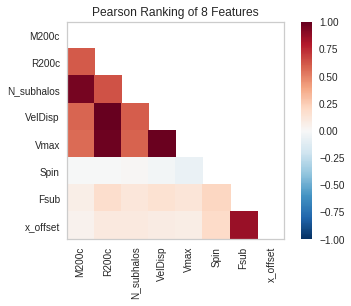

In [20]:
visualizer = Rank2D(features=feature_names, algorithm='pearson')

visualizer.fit(features, labels)
visualizer.transform(features)  
visualizer.poof()  

# Standarize features

In [23]:

scaler = StandardScaler()

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


Text(0,0.5,'cumulative explained variance')

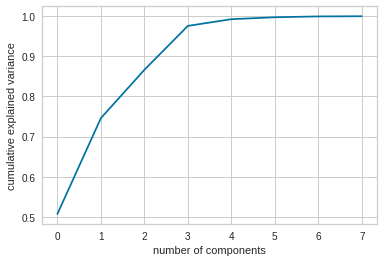

In [24]:
pca = PCA().fit(train_features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [25]:
n_components = 4

In [29]:

pca = PCA(n_components = 4)
pca.fit(train_features)

pca_train = pca.transform(train_features)

pca_test = pca.transform(test_features)
#pca_test_reconstruction = pca.inverse_transform(pca_test)

In [31]:
pca_names = [f'pca-{i}' for i in range(n_components)]

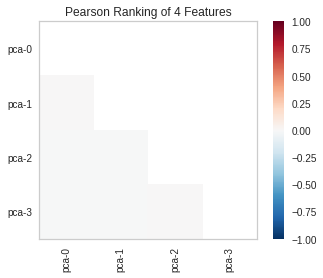

In [32]:
visualizer = Rank2D(features=pca_names, algorithm='pearson')

visualizer.fit(pca_train, labels)
visualizer.transform(pca_train)  
visualizer.poof()  

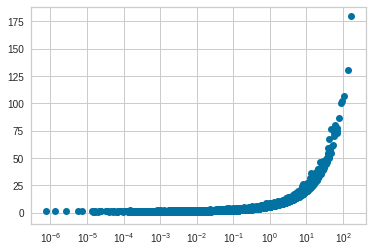

In [40]:
plt.semilogx(train_features[:, 0], pca_train[:,0], linestyle = '', marker = 'o')


# Random Forest on Features

In [41]:
n_estimators = 200

rf = RandomForestClassifier(n_estimators= n_estimators)

rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Normalized confusion matrix


(array([[0.93492956, 0.06507044],
        [0.05736825, 0.94263175]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2acb64799be0>)

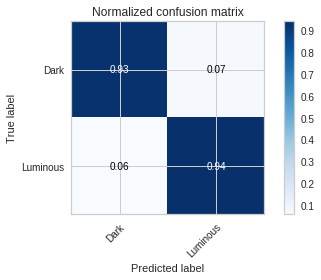

In [43]:
test_pred = rf.predict(test_features)
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

In [44]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                     axis=0)
indices = np.argsort(importances)[::-1]


In [52]:
feature_names = np.array(feature_names)

(-1, 8)

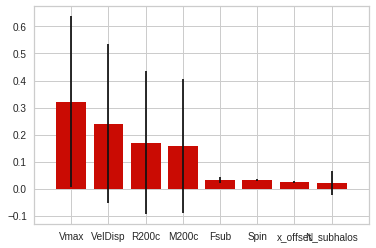

In [54]:
plt.bar(range(train_features.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), feature_names[indices])
plt.xlim([-1, train_features.shape[1]])


# Random Forest on PCAs

In [55]:
n_estimators = 200

rf = RandomForestClassifier(n_estimators= n_estimators)

rf.fit(pca_train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Normalized confusion matrix


(array([[0.92409309, 0.07590691],
        [0.06661986, 0.93338014]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2acb64d825f8>)

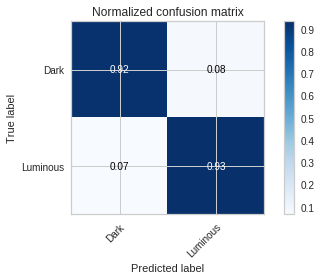

In [57]:
test_pred = rf.predict(pca_test)
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

In [58]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                     axis=0)
indices = np.argsort(importances)[::-1]


In [61]:
pca_names = np.array(pca_names)

(-1, 8)

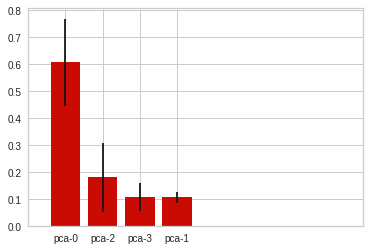

In [62]:
plt.bar(range(pca_train.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")

plt.xticks(range(pca_train.shape[1]), pca_names[indices])
plt.xlim([-1, train_features.shape[1]])
